# Three-dimensional lidar data classification of complex natural scenes with multi-scale features

<img src="images/logo-ipgp-upc.png" style="margin:10px; height:80px;"/>

The original version of this notebook was made by Antoine Lucas and Gregory Sainton. The current notebook was edited in 2023 by Leonard Seydoux (seydoux@ipgp.fr) to be used in the course _Earth Data Science_ at the [Institut de Physique du Globe de Paris](https://www.ipgp.fr/fr) (IPGP). If you have found a bug or have a suggestion, please feel free to contact me.

## 1. Introduction

The goal of this session is to classify a three-dimensional point cloud acquired by a lidar sensor, in order to allow for class-specific analysis. The classification will be based on the spatial distribution of the points in the three-dimensional space, and will be performed using a (semi) supervised machine learning approach. We here say semi-supervised because we will use a small set of labeled points to train the classifier, and then use it to classify the whole point cloud. One tedious task during the classification is the definition of relevant mmulti-scale features that will allow to discriminate between the different classes. We will here use a method based on the spatial distribution of the points in a three-dimensional sphere at various spatial scales.

During this session, we will use a point cloud acquired by a terrestrial lidar sensor on a beach, and containing two classes: sand and vegetation. We will base our classification on the paper by Brodu and Lague ([2012](https://www.sciencedirect.com/science/article/abs/pii/S0924271612000330)). Note that the final exam with be a hackathon that will consist in using the same method to classify a point cloud acquired in a forest, including four classes: paths, grass, trees and walls. 

![](./images/scene.png)

> __Final exam scene:__ point cloud contains 4 classes: paths, grass, trees and walls. This image was rendered with the online open-source project [plas.io](https://plas.io/).

The notebook uses the module `lidar` that is a wrapper of the `laspy` library to deal with lidar data. For more information about the functions and usage, please refer to the `lidar` module docstrings, and the [laspy documentation](https://laspy.readthedocs.io/en/latest/). Let's first make sure that your environment is properly set up by importing the required modules. If you encounter any error, please let us know as soon as possible so we can provide you with help.

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

import lidar

## 2. Data loading and visualization

### 2.1. The entire scene (unlabeled)

The entire scene contains all classes unlabeled. First, we can load the data and plot the points in a three-dimensional plot. We can have a look at it from different angles to get a better understanding of the scene. The current notebook uses the inline plotting of matplotlib, which does not provide interaction. For changing angles, you therefore need to rerun the cell with the `ax.view_init` command. If you prefer to use an interactive plot, you can use the `%matplotlib widget` magic command. Note that there is a big slowdown when using the interactive plot.

The entire scene contains almost two million points. This is too much to be displayed in a single plot in matplotlib. Other plotting libraries may handle such a number of points better. We can use the `lidar` module to load the data and plot a subset of the points. After reading the entire scene with the `lidar.read_las` function, you can use the `lidar.show_scene` function to show the scene. Note that the `show_scene` function takes a `n_points` parameter that allows to specify the number of points to display (randomly sampled). This is useful to speed up the plotting and to get a better understanding of the scene.

Note: The number of points `n_points`, point size `s` and transparency `alpha` are parameters that can be tuned to get a better visualization of the scene. These values were calibrated on a different computer, so you may need to adjust them to get a better visualization.

Total number of points in scene: 1,908,271


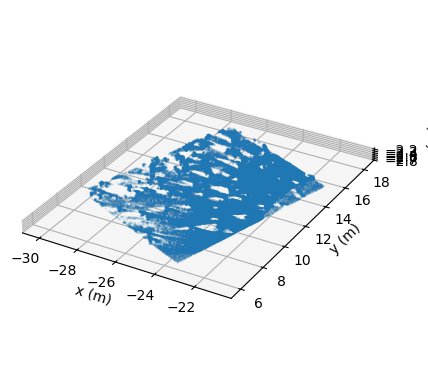

In [3]:
# Paths
DIRPATH_UNLABELED = "data-dunes/evaluation"
DIRPATH_LABELED = "data-dunes/labeled"

# Read the whole dataset
scene = lidar.read_xyz(os.path.join(DIRPATH_UNLABELED, "scene.xyz"))

# Get the shape of the dataset
print(f"Total number of points in scene: {scene.shape[0]:,}")

# Plot the scene
lidar.plot_scene(scene, s=0.1, alpha=0.1, n_points=250_000)

# Show
plt.show()

### 2.2. The labeled sets

The classes of objects have been identified manually in a subset of the data. These classes are located in the `./data/labeled/` folder. We can display them on the same plot to maje a difference between all scenes. Because these are extracted from the main dataset manually (by selecting rectangular subsets of the original dataset), we can actually speak about a classification problem (supervised), but another more accurate term would be a semi-supervised learning problem, where only a subset of the data is labeled.

> __Question 1.__ Read the various labeled classes and represent them in a plot with different colors. Note, in a first impression, what are the main differences between the classes in terms of spatial distribution of the points. This is not a question that requires a long answer nor a formal answer, but rather a first impression, in very plain language.
> 
> __Answer 1.__ The sand is flat and the vegetation is more heterogeneous. The density of points seems denser in some regions for the sand, but this is not very clear. At around 70 cm, the vegetation is more 3D and the sand is more 2D.

Dataset from file data-dunes/labeled/vegetation.xyz contains 4,608 points
Dataset from file data-dunes/labeled/floor.xyz contains 40,069 points


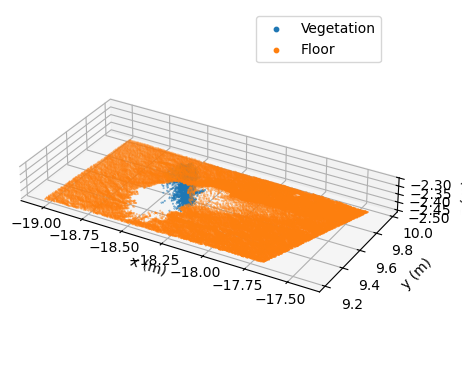

In [4]:
# Get paths to all the files in the folder
filepaths = glob.glob(os.path.join(DIRPATH_LABELED, "*.xyz"))

# Create figure and axes to plot every subset on
ax = plt.axes(projection="3d")

# Iterate over the files in the folder
for filepath in filepaths:
    # Read the whole dataset
    dataset = lidar.read_xyz(filepath)
    category = os.path.basename(filepath).replace(".xyz", "")

    # Get info
    print(f"Dataset from file {filepath} contains {dataset.shape[0]:,} points")

    # Plot a subsample of the dataset
    lidar.plot_scene(dataset, s=0.1, ax=ax, label=category.title())

# Labels
ax.legend(markerscale=10)
plt.show()

## 3. Feature extraction

In order to classify the points, we need to extract features from the point cloud. The features should be relevant to make a difference between the different classes. The features should also be invariant to the position of the points in the scene. For example, the height of the points is not a good feature because it depends on the position of the sensor. The features should also be invariant to the number of points in the scene. For example, the number of points in a given area is not a good feature because it depends on the distance between the sensor and the objects.

### 3.1. Local dimensionality at given scale

#### 3.1.1. Neighborhood ball

Following Brodu and Lague ([2012](https://www.sciencedirect.com/science/article/abs/pii/S0924271612000330)), an idea is to characterize the local dimensionality for each points of the cloud at different scales $d$. In other terms, considering a __neighborhood ball__ of diameter $d$ and center point $c = (x_c, y_c, z_c)$ called __scene point__, are the set of __neighbor points__ within this ball located on a line, a plane, or a volume? 

<figure style="margin: 50px">
    <img src="images/neighborhood_ball.png" width="700">
    <figcaption><b>Fig. 1: </b>Illustration from Brodu and Lague (2012) showing the neighborhood ball with various diameters, the scene point and neighbor points.</figcaption>
</figure>

#### 3.1.2. Principal component analysis

To answer this question, we can use the principal component analysis (PCA) to find the directions of maximum variance of the point cloud within a sphere. If the data varies mostly along a line, the variance in this direction will be much larger than the variance in the other directions, and therefore only one eigenvalue will be much larger than the others. If the data varies mostly along a plane, the variance in this plane will be much larger than the variance in the other directions, and therefore two eigenvalues will be much larger than the third one. Finally, if the data varies mostly in a volume, the variance in all directions will be similar, and therefore the three eigenvalues will be similar.

We can formally write this problem by considering a set of $n$ points $\mathbf{r} = \{\mathbf{r}_i\}_{i=1}^n$, with $\mathbf{r}_i = (x_i, y_i, z_i)$, located in a sphere of diameter $d$ and center point $\mathbf{r}_c = (x_c, y_c, z_c)$. The covariance matrix $\mathbf{C}$ of the points in the sphere is defined as:

$$
\mathbf{C} = \frac{1}{n} \sum_{i=1}^n (\mathbf{r}_i - \mathbf{r}_c) (\mathbf{r}_i - \mathbf{r}_c)^T.
$$

The covariance matrix is symmetric and positive semi-definite, so that it can be diagonalized as:

$$
\mathbf{C} = \mathbf{U} \mathbf{\Lambda} \mathbf{U}^T,
$$

where $\mathbf{U}$ is the matrix of eigenvectors and $\mathbf{\Lambda}$ is the diagonal matrix of eigenvalues. The eigenvectors are orthogonal and normalized, so that $\mathbf{U}^T \mathbf{U} = \mathbf{I}$, where $\mathbf{I}$ is the identity matrix. The diagonal matrix of eigenvalues $\mathbf{\Lambda}$ is defined as:

$$
\mathbf{\Lambda}= 
\begin{bmatrix}
\lambda_1 & 0 & 0 \\
0 & \lambda_2 & 0 \\
0 & 0 & \lambda_3
\end{bmatrix},
$$

where $\lambda_1 \geq \lambda_2 \geq \lambda_3 \geq 0$. We normalize the eigenvalues by the sum of all eigenvalues to make them invariant to the number of points in the sphere. The eigenvalues of the covariance matrix of the points in the sphere can be used to characterize the local dimensionality, as illustrated in the figure below.

<figure style="margin: 50px; width: 550px">
<img src="images/eigenvalues.png">
<figcaption><b>Fig. 2: </b>Illustration of the expected eigenvalues of the covariance matrix of the points in the sphere for different geometries.</figcaption>
</figure>

The eigenvalues are sorted in decreasing order, so that $\lambda_1$ is the largest eigenvalue and $\lambda_3$ is the smallest. The eigenvalues are normalized by the sum of all eigenvalues to make them invariant to the number of points in the sphere. The goal of this exercice is to define an algorithm that allow to extract the __neightboring points__ of all points in the cloud, compute the __eigenvalues of the covariance matrix__ of these points at different scales, and later use these eigenvalues as __features__ for the classification.

#### 3.1.3. Core points

In order to avoid computing the covariance and eigenvalues for all points in the cloud, we will first identify a subset of points called __core points__ that will be used to compute the features. The core points are defined as points with a sufficient number of neighbors within a given diameter $d$, and are initially sampled randomly.

Note that for some scales, the point cloud may be empty. In this case, the eigenvalues are set to NaNs and will be ignored in the classification. Actually, for robustness, we will systematically reject the points with a number of neighbors below a given threshold set by the `n_min_points` parameter.

> __Question 2.__ Read one of the two labeled subset of data. What is a relevant number of core points to consider in the study? Consider using the `lidar.sample` method to extract the number of core points you have chosen. Then, extract the eigenvalues for all sphere centered in the core points at a given scale defined by the diamater variable with the `lidar.calculate_eigenvalues` method. How many core point did not have enough neighbors to compute the eigenvalues? What about if you execute the cell again, with the same scale and for different scales? Repeat this operation for the other classes to get a rought idea of the number of core points that can be used for the classification.
> 
> __Answer 2.__ The number of core points should be large enough to be representative of the scene, but not too large to avoid a too long computation time. A good value is around 1000 in our case. The number of core points that do not have enough neighbors to compute the eigenvalues depends on the scale. For a scale of 0.1 m, there are <5 core points that do not have enough neighbors. For a scale of 0.5 m, there are 0 core points that do not have enough neighbors. 

In [5]:
N_CORE_POINTS = 1000
N_MIN_POINTS = 10
DIAMETER = 0.3

# Load the dataset
points = lidar.read_xyz(filepaths[1])
print("Read dataset from file:", filepaths[1])

# Consider a subset of the dataset (e.g., core points) to extract features from
core_points = lidar.sample(points, N_CORE_POINTS)

# Calculate eigenvalues
eigenvalues = lidar.calculate_eigenvalues(core_points, points, DIAMETER, N_MIN_POINTS)

# Info
print(f"Number of core points: {len(eigenvalues):,}")
print(f"Number of outliers: {np.isnan(eigenvalues).any(axis=1).sum():,}")

Read dataset from file: data-dunes/labeled/floor.xyz
Number of core points: 1,000
Number of outliers: 0


### 3.2. Natural representation of the eigenvalues

Any covariance matrix $\mathbf{C} \in \mathbb{R}^{3 \times 3}$ delivers eigenvalues $\lambda_1$, $\lambda_2$ and $\lambda_3$ such as $\lambda_1 \geq \lambda_2 \geq \lambda_3 \geq 0$ because the covariance matrix is symmetric and positive semi-definite. Without normalization, the three eigenvalues are not invariant to the number of points in the sphere, and can take any arbitrary value. To make the eigenvalues invariant to the number of points in the sphere, we can normalize them by the sum of all eigenvalues. This way, the sum of the eigenvalues is always equal to 1.

<figure style="margin: 50px; width: 550px">
<img src="images/eigentriangle.png">
<figcaption><b>Fig. 3: </b>Expected behaviour of the eigenvalues.</figcaption>
</figure>

Once normalized, the eigenvalues all fall in the triangular region delimited represented in the the figure above.

> __Question 3.__ Extract the three eigenvalues for all core points at a given scale, and plot them in a similar diagram as the one above. What is the behavior of the eigenvalues with respect to the input scale and dataset? 
>
> __Answer 3.__ The eigenvalues are all in the triangular region delimited by the triangle shown in the example above. For the sand, at a scale of 30 cm, the first two eigenvalues are mostly equal and the third one is close to 0, relating to a 2D spatial distribution of the points. At the same scale for the vegetation, we observe a more 3D distribution of the points with equal-value all three eigenvalues.

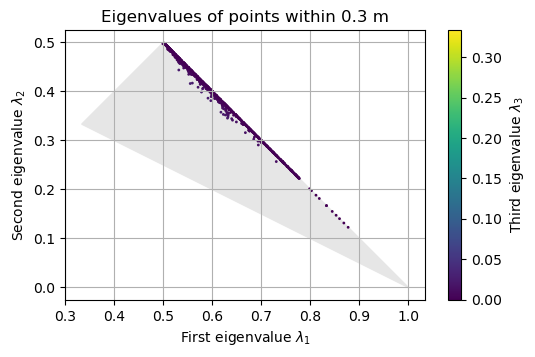

In [6]:
# Extract eigenvalues
l1, l2, l3 = eigenvalues.T

# Plot
fig, ax = plt.subplots(figsize=(6, 3.5))
mappable = ax.scatter(l1, l2, c=l3, s=1, rasterized=True, vmin=0, vmax=1 / 3)

# Labels
cb = plt.colorbar(mappable, ax=ax)
cb.set_label(r"Third eigenvalue $\lambda_3$")
ax.set_xlabel(r"First eigenvalue $\lambda_1$")
ax.set_ylabel(r"Second eigenvalue $\lambda_2$")
ax.set_title(f"Eigenvalues of points within {DIAMETER} m")
ax.set_aspect("equal")
ax.grid()

# Add eigenvalue triangle patch for reference
triangle_summits = [(1 / 3, 1 / 3), (0.5, 0.5), (1, 0)]
triangle = plt.Polygon(triangle_summits, color="0.9", zorder=-1)
ax.add_patch(triangle)

# Show
plt.show()

### 3.3. Ternary representation of the eigenvalues

Because of the normalization, the eigenvalues are always positive and sum to 1. Therefore, only two eigenvalues are necessary to represent the three eigenvalues. In other words, they can be represented as a point in a 2D plane, using the barycentric coordinates. For more information about the barycentric coordinates, you can read the [Wikipedia page](https://en.wikipedia.org/wiki/Barycentric_coordinate_system). We provide you here with a function to convert the eigenvalues to barycentric coordinates called `lidar.calculate_barycentric_coordinates`. The function takes as input the three eigenvalues and returns the barycentric coordinates. Another routine, called `lidar.plot_ternary`, allows to plot the barycentric coordinates in a ternary diagram. The ternary diagram is a triangular diagram where the three corners represent the three eigenvalues. The ternary diagram is a compact representation of the eigenvalues, and allows to easily visualize the distribution of the points in the triangular region.

The colormap of the ternary plot depends on the local density of the points calculated with a Gaussian kernel density estimation (KDE). The KDE is computed with the `scipy.stats.gaussian_kde` function.

> __Question 4.__ Extract the three eigenvalues for all core points at a given scale, and plot them in a ternary diagram. Repeat the comments you made in the previous question with the ternary diagram. 
>
> __Answer 4.__ The ternary diagram shows the same information as the triangular diagram, but in a more compact way. The sand is mostly located in the bottom left corner, and the vegetation is mostly located in the top right corner. The sand is mostly 2D, and the vegetation is mostly 3D.

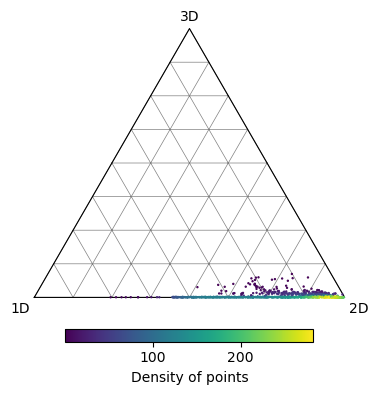

In [7]:
# Ternary plot of the eigenvalues
barycenters = lidar.calculate_barycentric_coordinates(eigenvalues)
lidar.plot_ternary(*barycenters)

# Show
plt.show()

### 3.4. Multi-scale feature extraction

Now, we can extract the barycentric coordinates of all points in the cloud at different scales. For each scale $d$, we obtain a set of barycentric coordinates $(x_d, y_d)$ where $x_d$ and $y_d$ are the barycentric coordinates of the core points. We will define the features as the concatenation of all barycentric coordinates at different scales. In other words, the features are defined as:

$$
\mathbf{f} = \left[ x_1, y_1, x_2, y_2, \dots, x_D, y_D \right] \in \mathbb{R}^{2D}
$$

where $D$ is the number of scales. The number of scales $D$ is a parameter that can be tuned to get a better classification. These values were calibrated on a different computer, so you may need to adjust them to get a better classification.

> __Question 5.__ Extract the barycentric coordinates for all points in the cloud at different scales, and concatenate them to get the features. How many scales will you select, and how many core points will you use per dataset? 
>
> __Answer 5.__ The number of scales should be large enough to capture the spatial distribution of the points, but not too large to avoid a too long computation time. A good value is 3 scales in our case, ranging from 5 cm to 50 cm. 

/var/folders/vb/xqq7d5zj58l1hwcqvtq16zf00000gn/T/ipykernel_78107/2402958575.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features = pd.concat([features, dataset_features])


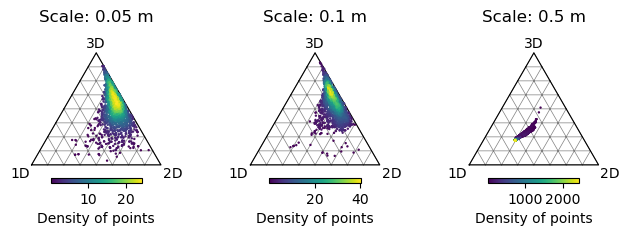

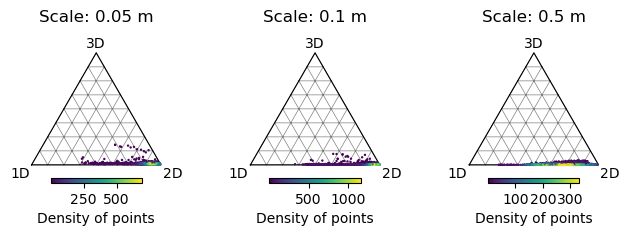

In [8]:
SCALES_IN_M = 0.05, 0.1, 0.5
N_CORE_POINTS = 2000
N_MIN_POINTS = 10

# Create empty list of features
scale_x_features = [f"scale_{scale}_x" for scale in SCALES_IN_M]
scale_y_features = [f"scale_{scale}_y" for scale in SCALES_IN_M]

# Create empty dataset
features = pd.DataFrame(columns=scale_x_features + scale_y_features + ["category"])

for filepath in filepaths:

    # Create figures
    fig, axes = plt.subplots(1, len(SCALES_IN_M), figsize=(8, 2), sharey=True)

    # Calculate features
    points = lidar.read_xyz(filepath)
    core_points = lidar.sample(points, N_CORE_POINTS)
    dataset_features = pd.DataFrame(columns=features.columns)
    category = os.path.basename(filepath).replace(".xyz", "")

    for ax, scale in zip(axes, SCALES_IN_M):

        # Calculate eigenvalues (in parallel)
        eigenvalues = lidar.calculate_eigenvalues(core_points, points, scale, N_MIN_POINTS)

        # Calculate tertiary coordinates
        x, y = lidar.calculate_barycentric_coordinates(eigenvalues)

        # Add to the dataframe
        dataset_features[f"scale_{scale}_x"] = x
        dataset_features[f"scale_{scale}_y"] = y
        dataset_features["category"] = category    

        # Plot
        lidar.plot_ternary(x, y, ax=ax)

        # Labels
        ax.set_title(f"Scale: {scale} m\n")

    # Turn into a dataframe
    features = pd.concat([features, dataset_features])

# Reset index
features = features.reset_index(drop=True)

## 4. Classification (training and testing)

Now that we have extracted the features, we can use them to train a classifier. We will compare the performance of different classifiers, as we did in the previous notebook. We will use the same classifiers as in the previous notebook on the IRIS dataset, but we will use the features extracted from the point cloud instead of the features extracted from the flowers.

### 4.1. Split the dataset into a training set and a test set 

In order to train a classifier correctly, we need to split the dataset into a training set and a test set. The training set will be used to train the classifier, and the test set will be used to evaluate the performance of the classifier. We will use the `train_test_split` function from scikit-learn to split the dataset into a training set and a test set. We will use 80% of the dataset for training and 20% for testing. 

> __Question 6.__ Split the dataset into a training set and a test set. How many points will you use for training and testing? Is it a good idea to use all points for training? Do not forget to remove the NaNs from the features and labels before splitting the dataset, and to take this into account before the splitting.
>
> __Answer 6.__ We will use 80% of the points for training and 20% for testing. It is not a good idea to use all points for training because we will not be able to evaluate the performance of the classifier in this case.

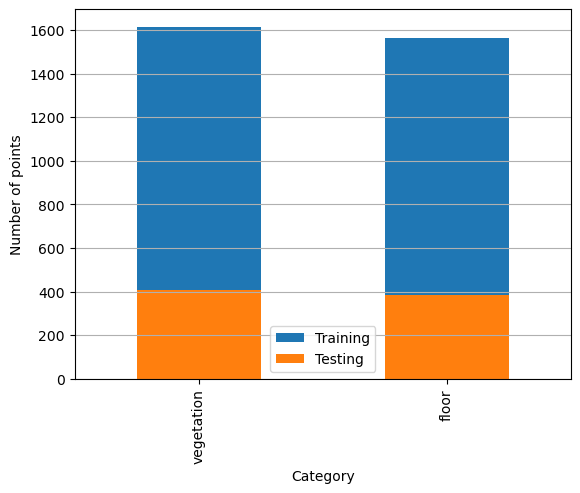

In [9]:
from sklearn.model_selection import train_test_split

# Remove rows with NaN values
features_clean = features.dropna()

# Split features and labels
x = features_clean.drop({"category"}, axis=1)
y = features_clean["category"].copy()

# Split data randomly into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

# Plot the training and test labels distribution with bars of different colors
fig, ax = plt.subplots()
y_train.value_counts().plot.bar(ax=ax, label="Training", color="C0")
y_test.value_counts().plot.bar(ax=ax, label="Testing", color="C1")

# Labels
ax.set_ylabel("Number of points")
ax.set_xlabel("Category")
ax.grid(axis="y")
ax.legend()

# Show
plt.show()

### 4.2. Train the classifier

As in the previous cases, we will import and create an instance of the classifier, and then train it with the training set using the `fit` method. We will then use the classifier to predict the labels of the test set using the `predict` method. Finally, we will evaluate the performance of the classifier using the various metrics provided by scikit-learn.

> __Question 7.__ Choose a classifier wisely. Which one will you consider? Is our problem a linearly-separable problem, and how to even answer this question? Train the classifier and evaluate its performance. How do you really evaluate the performance of a classifier?
> 
> __Answer 7.__ We will use a Support Vector Machine (SVM) classifier (hereafter called SVC). We start with this one because it remains interpretable and fast to run. Althgouth the problem is not linearly separable, the SVC can be used with a non-linear kernel, helping us to understand if we should consider more non-linear algorithms. In order to evaluate the performance of the classifier, we will use the confusion matrix. 

Accuracy on the train data: 100.00%
Accuracy on the test data: 100.00%
Overall accuracy: 100.00%


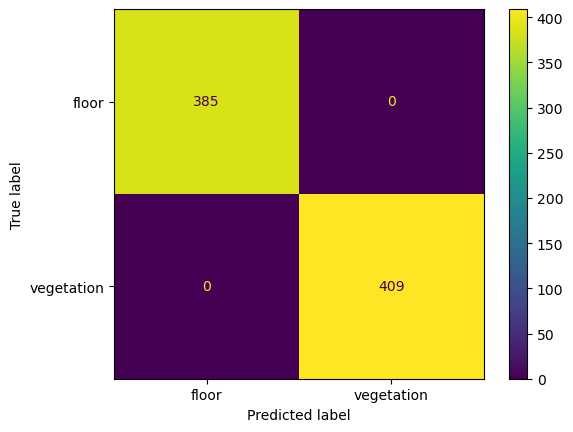

In [10]:
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

# Instantiate the model
model = SVC()

# Fit the model
model.fit(x_train, y_train)

# Predict the test data
y_test_pred = model.predict(x_test)
category_names = model.classes_

# Show confusion matrix on the predicted test data
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=category_names)

# Accuracies
score_train = model.score(x_train, y_train)
score_test = model.score(x_test, y_test)
score = model.score(x, y)

print(f"Accuracy on the train data: {score_train:.2%}")
print(f"Accuracy on the test data: {score_test:.2%}")
print(f"Overall accuracy: {score:.2%}")

## 5. Evaluation on the entire dataset

This is obviously the most important part, or at least the main objective of the project. You will need to apply the classifier to the entire dataset and visualize the results. Of course, there are many things that you can improve by playing around with the different parameters such as the scales, the dataset size, and so. 

### 5.1. Feature extraction

First, we need to extract __the same features__ as in the training phase on the labeled dataset. We will use the same scales. We will then use the classifier to predict the labels of the points in the dataset. 

> __Question 8.__ Extract the features for all points in the dataset. How many points will you use?
>
> __Answer 8.__ See answer in the cell below.

In [11]:
# Read again the entire dataset
dataset = lidar.read_xyz(os.path.join(DIRPATH_UNLABELED, "scene.xyz"))

# Core points
core_points = dataset[::100]
print(f"Number of core points: {len(core_points):}")

# Read pickle file features
# Create empty list of features
scale_x_features = [f"scale_{scale}_x" for scale in SCALES_IN_M]
scale_y_features = [f"scale_{scale}_y" for scale in SCALES_IN_M]

# Feature dataframe
new_features = pd.DataFrame(columns=scale_x_features + scale_y_features)
for scale in tqdm.tqdm(SCALES_IN_M, desc=f"Processing"):

    # Calculate eigenvalues (in parallel)
    eigenvalues = lidar.calculate_eigenvalues(core_points, dataset, scale, N_MIN_POINTS)
    
    # Calculate tertiary coordinates
    x, y = lidar.calculate_barycentric_coordinates(eigenvalues)

    # Add to the dataframe
    new_features[f"scale_{scale}_x"] = x
    new_features[f"scale_{scale}_y"] = y

# Reset index
new_features = new_features.reset_index(drop=True)

Number of core points: 19083


Processing: 100%|██████████| 3/3 [00:36<00:00, 12.31s/it]


### 5.2. Prediction

Now we can use the classifier to predict the labels of the points in the dataset. We will use the `predict` method of the classifier to predict the labels of the points in the dataset. Now it's the visualization part!

> __Question 9.__ Visualize the results.
>
> __Answer 9.__ See answer in the cell below.

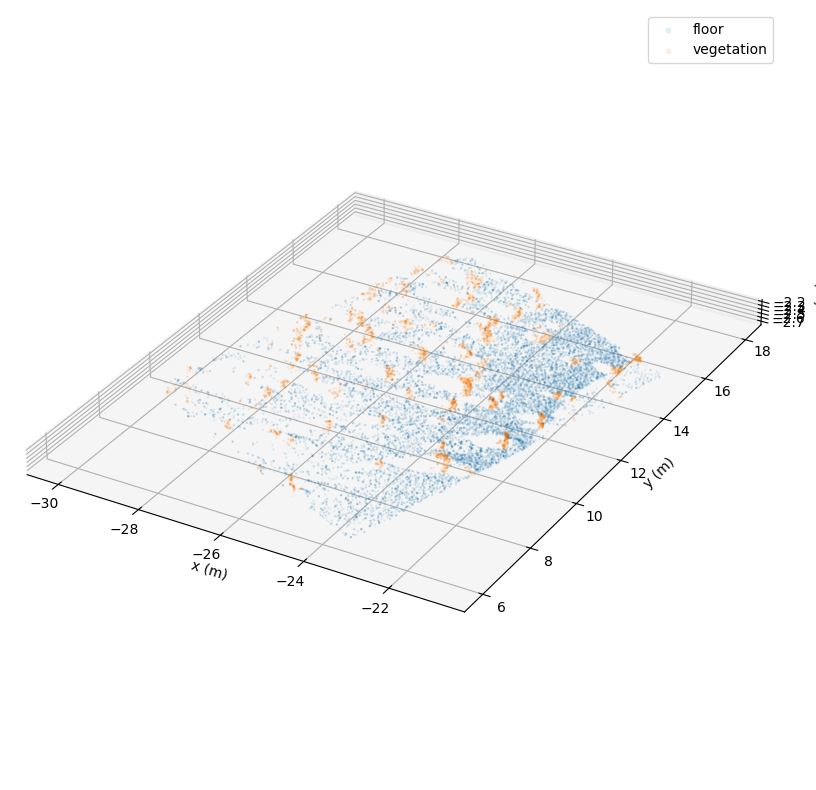

In [12]:
# Predict
new_features_clean = new_features.dropna()
core_points_clean = core_points[new_features_clean.index]
y_pred = model.predict(new_features_clean)

# Transform strings to integers
category_names = model.classes_.tolist()
y_pred = np.array([category_names.index(category) for category in y_pred])

# Plot
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(10, 10))
for y_class in np.unique(y_pred):

    # Get points from the same class
    points_within_class = core_points_clean[y_pred == y_class]

    # Plot
    lidar.plot_scene(
        points_within_class,
        s=0.4,
        alpha=0.1,
        n_points=40000,
        ax=ax,
        c=f"C{y_class}",
        label=category_names[y_class],
    )

# Labels
ax.legend(markerscale=5)
plt.show()


## 6. Bonus: clustering

OK, now that we obtained some results, we can try also another approach: clustering. We will use the same features as in the classification part, but we will use a clustering algorithm instead of a classifier. This may allow us to discover some new classes that we did not know about, or that we did not label. 

Similarly than for classification, clustering algorithms are available in scikit-learn, and you can find various algorithms in the [clustering section](https://scikit-learn.org/stable/modules/clustering.html) of the scikit-learn documentation. You can also find a [tutorial on clustering](https://scikit-learn.org/stable/modules/clustering.html) in the scikit-learn documentation.